In [1]:
import dynamiqs as dq
import jax.numpy as jnp
import numpy as np

Define units:

In [2]:
GHz = 1.0
MHz = 1e-3 * GHz
kHz = 1e-3 * MHz

Define system parameters:

In [3]:
omega_a_0 = 5.26 * GHz # bare resonant frequency of mode a
omega_b_0 = 7.7 * GHz # bare resonant frequency of mode b

phi_a = 0.06 # zero-point fluctuation phase of mode a
phi_b = 0.29 # zero-point fluctuation phase of mode a
e_J = 12.03 * GHz # Josephson energy
delta_e_J = 0.47 * GHz

kappa_a = 9.3 * kHz # relaxation rate of mode a
kappa_b = 2.6 * MHz # relaxation rate of mode b

g2_target = 0.763*MHz # target g2 used to specify driving strength of ATS
alpha_target = np.sqrt(5.0) # target alpha, (or equivalently specify number of photons)

#driving strengths:
epsilon_p = 2*g2_target/(e_J * phi_a**2 * phi_b) # flux pump power
epsilon_d = -alpha_target**2 * np.conj(g2_target) # buffer pump power

In [4]:
epsilon_p

0.12150339349582621

In [5]:
epsilon_d

-0.0038150000000000007

### Compute AC Stark shift

In [6]:
#initialization:
delta_a, delta_b = (0.0,0.0) # set initial AC Stark shifts to zero
omega_p = 2*omega_a_0 - omega_b_0 # initial frequency matching condition

#recursion loop to compute AC Stark shift:
rec_depth = 30
for i in range(rec_depth):
    #compute xi for mode a and b:
    alpha_1 = 1j*e_J*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 - omega_p))
    alpha_2 = 1j*e_J*epsilon_p*phi_a / (kappa_a/2 + 1j*(omega_a_0 + omega_p))

    beta_1 = 1j*e_J*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 - omega_p))
    beta_2 = 1j*e_J*epsilon_p*phi_b / (kappa_b/2 + 1j*(omega_b_0 + omega_p))

    pre = (np.real(alpha_1) + np.real(alpha_2)) * phi_a \
    + (np.real(beta_1) + np.real(beta_2)) * phi_b
    #compute AC Stark shifts:
    delta_a = 1/3*e_J * epsilon_p * phi_a**2 * pre 
    delta_b = 1/3*e_J * epsilon_p * phi_b**2 * pre 

    #recompute frequencies
    omega_a = omega_a_0 - 2*delta_e_J*phi_a**2 + delta_a 
    omega_b = omega_b_0 - 2*delta_e_J*phi_b**2 + delta_b 
    omega_p = 2*omega_a - omega_b

omega_d = omega_b

### Construct Hilbert space operators

In [7]:
#Fock-space dimension in the memory mode:
n_fock_a = 30
#Fock-space dimension in the buffer mode:
n_fock_b = 7

#annihilation operators:
a, b = dq.destroy(n_fock_a, n_fock_b)

#identity operator:
identity = dq.tensor(dq.eye(n_fock_a), dq.eye(n_fock_b))

Define ATS driving term

In [8]:
# define the ATS driving term
eps_ats = lambda t: epsilon_p*jnp.cos(omega_p*t)

Define time-dependent displaced-rotated operator:

In [9]:
def op_rot_displaced(t, op, omega_rot, dis):
    return op*jnp.exp(-1j*omega_rot*t) + dis * identity

### Define time-dependent Hamiltonian in the displaced-rotated frame
The Hamiltonian consists of 5 parts:

`h_0`: bare non-interacting Hamiltonian

`h_ATS`: Hamiltonian of the ATS

`h_buffer_drive`: Hamiltonian of the buffer drive

`h_rot`: Term from derivative of rotating frame

`h_dis`: Term from derivative of displaced frame

In [10]:
def hamiltonian_rotating_displaced(t):

    #compute displacement fields
    alpha_t = alpha_1*jnp.exp(-1j*omega_p*t) + alpha_2*jnp.exp(1j*omega_p*t)
    beta_t = beta_1*jnp.exp(-1j*omega_p*t) + beta_2*jnp.exp(1j*omega_p*t)


    # the displaced rotating frame introduces a drive and detuning
    d_alpha_t = 1j*omega_p * (alpha_2*jnp.exp(1j*omega_p*t) - alpha_1*jnp.exp(-1j*omega_p*t))
    d_beta_t = 1j*omega_p * (beta_2*jnp.exp(1j*omega_p*t) - beta_1*jnp.exp(-1j*omega_p*t))


    #compute rotated displaced operators:
    #...
    omega_rot_a = (omega_p + omega_d)/2
    omega_rot_b = omega_d
    a_f = op_rot_displaced(t, a, omega_rot_a, alpha_t)
    adag_f = dq.dag(a_f)
    b_f = op_rot_displaced(t, b, omega_rot_b, alpha_t)
    bdag_f = dq.dag(b_f)

    #displaced rotated phase operator
    phi_f = phi_a*(a_f + adag_f) + phi_b*(b_f + bdag_f)

    #linear term
    h_0 = omega_a_0 * adag_f @ a_f + omega_b_0 * bdag_f @ b_f
    
    #term from derivative of rotating frame
    h_rot = - omega_rot_a * dq.dag(a) @ a  - omega_rot_b * dq.dag(b) @ b
    
    #term from derivative of displaced frame
    h_dis =  -1j*(d_alpha_t*dq.dag(a)*jnp.exp(1j*omega_rot_a*t)-jnp.conj(d_alpha_t)*a*jnp.exp(-1j*omega_rot_a*t)) \
      - 1j*(d_beta_t*dq.dag(b)*jnp.exp(1j*omega_rot_b*t)-jnp.conj(d_beta_t)*b*jnp.exp(-1j*omega_rot_b*t))
        

    #ats term:
    sinterm = jnp.sin(eps_ats(t)) * dq.sinm(phi_f)
    costerm = jnp.cos(eps_ats(t)) * dq.cosm(phi_f)
    h_ats = - 2*e_J*sinterm +  2*delta_e_J*costerm 
    
    #drive on the buffer:
    # in the rotating frame, this term is non-rotating
    h_buffer_drive = jnp.conj(epsilon_d)*jnp.exp(1j*omega_d*t)*b_f \
        + epsilon_d * jnp.exp(-1j*omega_d*t) * bdag_f
    
    return h_0 + h_ats + h_buffer_drive + h_rot + h_dis

In [11]:
# Make Hamiltonian time-callable JAX function:
H = dq.timecallable(hamiltonian_rotating_displaced)

C:\Users\Aradh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\equinox\_module.py:1096: UserWarning: A `SparseDIAQArray` has been converted to a `DenseQArray` while computing its matrix exponential.
  return self.__func__(self.__self__, *args, **kwargs)
C:\Users\Aradh\AppData\Local\Temp\ipykernel_5912\3821069200.py:46: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return h_0 + h_ats + h_buffer_drive + h_rot + h_dis
C:\Users\Aradh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\dynamiqs\qarrays\qarray.py:481: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return self.__add__(y)


C:\Users\Aradh\AppData\Local\Temp\ipykernel_5912\3821069200.py:46: UserWarning: A sparse qarray has been converted to dense layout due to element-wise addition with a dense qarray.
  return h_0 + h_ats + h_buffer_drive + h_rot + h_dis
|██████████| 100.0% ◆ elapsed 4.88s ◆ remaining 0.00ms
100%|██████████| 50/50 [00:07<00:00,  6.39it/s]


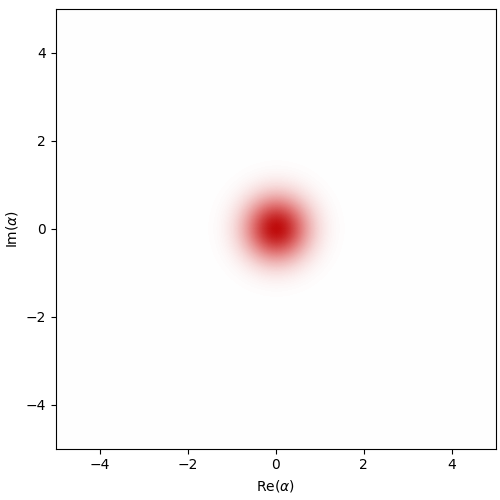

In [12]:
psi0 = dq.fock((n_fock_a,n_fock_b), (0,0))  # coherent state
t = jnp.linspace(0,1,50)
res = dq.mesolve(H, [jnp.sqrt(kappa_b)*b, jnp.sqrt(kappa_a)*a], psi0, t)

trace_a = dq.ptrace(res.states, 0,res.states.dims) # trace of a

dq.plot.wigner_gif(trace_a, fps=120)